In [118]:
import networkx as nx
import numpy as np
import scipy as sp
from scipy.sparse import rand
from itertools import combinations
from scipy.sparse import csr_matrix

np.random.seed(42)

def generate_adj_matrix(people_number, fill_factor = 0.5):
    fill_coeff = int(people_number * fill_factor)
    adj_matrix = sp.sparse.rand(people_number,
                                people_number,
                                density = fill_factor,
                                format = 'csr',
                                random_state = np.random.randint(1))

    adj_matrix = adj_matrix.todense()
    adj_matrix[np.arange(people_number), np.arange(people_number)] = 0
    adj_matrix = adj_matrix - adj_matrix.T
#     adj_matrix[adj_matrix < 0] = 0
    
    return csr_matrix(adj_matrix)

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


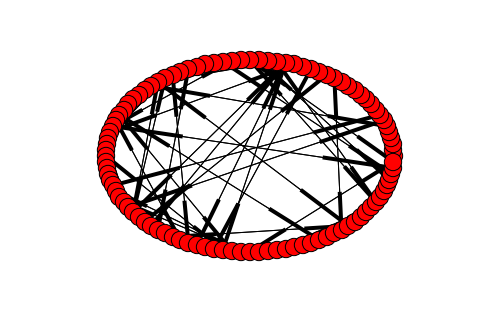

In [119]:
import matplotlib.pyplot as plt 
%matplotlib inline

G = nx.DiGraph(generate_adj_matrix(100, 0.005))

nx.draw_circular(G)

In [140]:
people_number = 5
adj_matrix = generate_adj_matrix(people_number, 0.5)

debtors = []
creditors = []
d = []
c = []

for i in range(people_number):
    row_sum = adj_matrix[i, :].sum()
    
    if row_sum >= 0:
        debtors.append(i)
        d.append(row_sum)
    else:
        creditors.append(i)
        c.append(row_sum)

In [129]:
adj_matrix[1, :].sum()

1.4807424336743398

In [137]:
creditors

[0, 3, 4]

In [134]:
debtors

[1, 2]

In [139]:
adj_matrix.todense()

matrix([[ 0.        , -0.38323649, -0.06615208,  0.        ,  0.        ],
        [ 0.38323649,  0.        ,  0.14035078,  0.95715516,  0.        ],
        [ 0.06615208, -0.14035078,  0.        ,  0.47360805,  0.19120773],
        [ 0.        , -0.95715516, -0.47360805,  0.        ,  0.15223594],
        [ 0.        ,  0.        , -0.19120773, -0.15223594,  0.        ]])

In [141]:
c

[-0.44938857428473844, -1.2785272645161001, -0.34344366795013292]